In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd

# Data loading

In [2]:
DATASET_ROOT_DIR = "../data/"
dataset_path = os.path.join(DATASET_ROOT_DIR, "dataset_big_patent_v1.json")

In [3]:
# Loading dataset
with open(dataset_path, "r") as json_file:
    dataset = json.load(json_file)

df = pd.DataFrame(dataset)
df.head(10)


,query,negative,pos
0,What are the key advantages and applications o...,The present technology introduces an innovativ...,RELATED APPLICATIONS This application claims t...
1,How does a magnetic energy harvester operate w...,The advanced energy accumulation equipment bei...,RELATED APPLICATIONS This application claims t...
2,How does an energy harvester operate without a...,The invention relates to the design and utilit...,RELATED APPLICATIONS This application claims t...
3,How can buffer blocks for ruminant animals be ...,The innovative technique pertains to mineral s...,BACKGROUND OF THE INVENTION I. Field of the In...
4,What advancements does the described patent pr...,The current text discusses a novel mechanical ...,RELATED APPLICATION The present application cl...
5,What advancements does the new stent delivery ...,This invention pertains to devices designed fo...,STATEMENT REGARDING FEDERALLY SPONSORED RESEAR...
6,What improvements does the described invention...,The discussed technology pertains to devices c...,STATEMENT REGARDING FEDERALLY SPONSORED RESEAR...
7,What are the properties and pharmaceutical app...,This submission concerns novel synthetic strat...,This appication is a Provisional application S...
8,What system employs thermal ablation for tissu...,The technological advancement in question pert...,CROSS-REFERENCE TO RELATED APPLICATIONS The pr...
9,What advancements in thermal ablation systems ...,A novel thermal ablation procedure for tissue ...,CROSS-REFERENCE TO RELATED APPLICATIONS The pr...


# Data analysis

## Dataset structure

In [4]:
print(f"Number of samples in dataset: {len(dataset)}")

Number of samples in dataset: 499


#### Study length distributions of entries

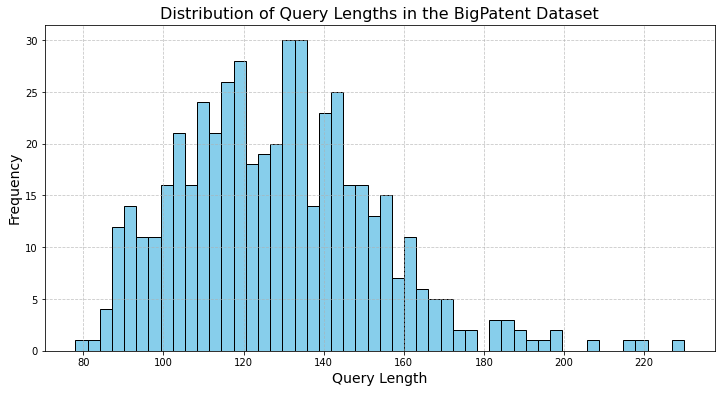

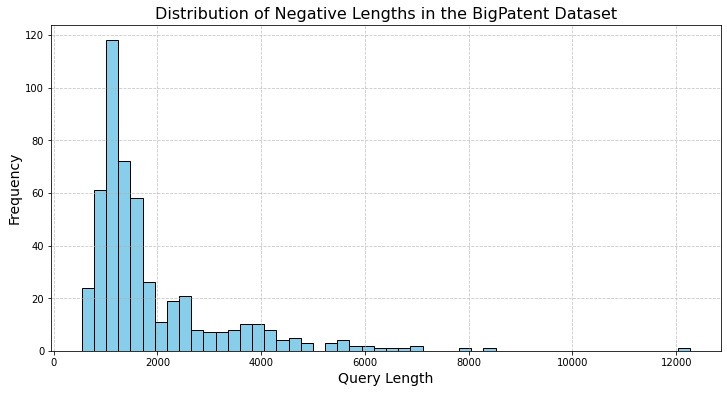

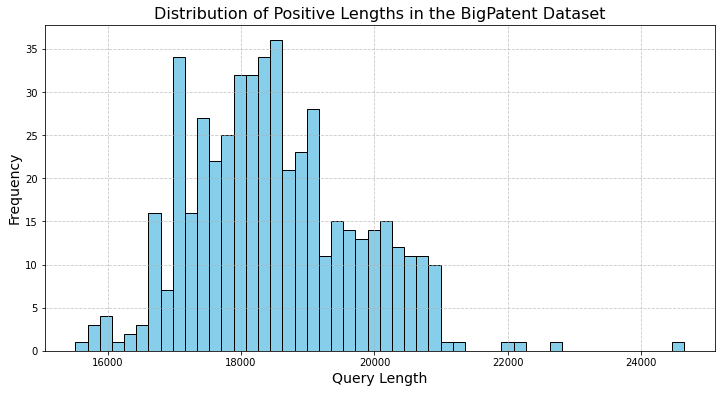

In [5]:
# Queries
plt.figure(figsize=(12, 6))
plt.hist(df['query'].apply(len), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Query Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Query Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Negatives
plt.figure(figsize=(12, 6))
plt.hist(df['negative'].apply(len), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Negative Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Query Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Positives
plt.figure(figsize=(12, 6))
plt.hist(df['pos'].apply(len), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Positive Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Query Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

#### Word Frequency

In [6]:
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: matlabengineforpython R2022a has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of matlabengineforpython or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [7]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def stem_words(text, stemmer):
    words = word_tokenize(text)
    stemmed_text = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_text)

def lemmatize_words(text, lemmatizer):
    words = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word, wordnet.VERB) for word in words]
    return ' '.join(lemmatized_text)

def get_most_common_words(texts, num_words=20):
    all_words = [word.lower() for text in texts for word in word_tokenize(text)]
    word_freq = Counter(all_words)
    return word_freq.most_common(num_words)

# Remove stop words, then apply stemming and lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for column in df:
    df[column] = df[column].apply(remove_stop_words)
    df[column] = df[column].apply(stem_words, args=[stemmer])
    df[column] = df[column].apply(lemmatize_words, args=[lemmatizer])
    
print("Most common words in queries:", get_most_common_words(df['query'].tolist()))
print("Most common words in negatives:", get_most_common_words(df['negative'].tolist()))
print("Most common words in positives:", get_most_common_words(df['pos'].tolist()))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YBT1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YBT1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most common words in queries: [(',', 554), ('?', 499), ('featur', 101), ('patent', 90), ('method', 86), ('improv', 84), ('innov', 75), ('describ', 73), ('devic', 69), ('use', 61), ('design', 57), ('system', 52), ('offer', 51), ('novel', 49), ('applic', 47), ('invent', 47), ('new', 46), ('advanc', 40), ('apparatu', 37), ('enhanc', 34)]
Most common words in negatives: [(',', 6664), ('.', 5926), ('[', 1030), (']', 1030), ('system', 767), ('devic', 680), ("'s", 648), ('design', 608), ('includ', 561), ('invent', 525), ('use', 508), ('mechan', 475), ('within', 399), ('structur', 389), ('compon', 366), ('specif', 357), ('enhanc', 344), ('process', 342), ('innov', 336), ('variou', 336)]
Most common words in positives: [(',', 74289), ('.', 67455), ('[', 11476), (']', 11476), (')', 11025), ('(', 10652), ('fig', 9122), (';', 8627), ('invent', 7852), ('may', 6838), ('use', 6790), ('embodi', 4840), ('present', 4566), ('includ', 4460), ('provid', 4252), ('devic', 4246), ('one', 4186), ('show', 4077)

#### TF-IDF

Top 20 words by TF-IDF score: [('devic', 0.08828195085697092), ('invent', 0.08615529710172565), ('use', 0.08279101014562482), ('design', 0.06752019754225903), ('fig', 0.06580622889330486), ('method', 0.06377725184985232), ('includ', 0.05396591124923311), ('applic', 0.053881670998814524), ('provid', 0.05231477757981237), ('present', 0.04993533956596598), ('describ', 0.04877247567919987), ('apparatu', 0.04755764150807521), ('patient', 0.04629123415901958), ('mechan', 0.04465833057157905), ('process', 0.042915307824421135), ('composit', 0.04291117270468205), ('compound', 0.04143313791036877), ('activ', 0.040253863982017406), ('structur', 0.03894413502581393), ('materi', 0.03865005504082185)]


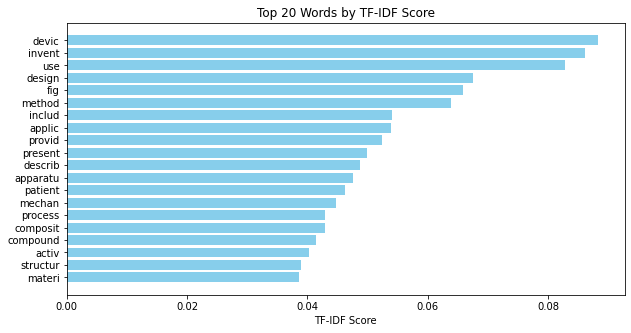

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all texts for TF-IDF calculation
all_texts = df['query'].tolist() + df['negative'].tolist() + df['pos'].tolist()

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)

# Get feature names (words) and their TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]
tfidf_scores = list(zip(feature_names, tfidf_scores))
tfidf_scores.sort(key=lambda x: x[1], reverse=True)

# Display top 20 words by TF-IDF score
print("Top 20 words by TF-IDF score:", tfidf_scores[:20])

# Extract top 20 words by TF-IDF score for bar chart
top_words = tfidf_scores[:20]
words, scores = zip(*top_words)

plt.figure(figsize=(10, 5))
plt.barh(words, scores, color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score')
plt.show()

# Zero-shot performances

In [9]:
from transformers import AutoTokenizer, AutoModel
import yaml

from utils import add_attr_interface
from zero_shot import get_embeddings

cfg_path = "./config.yml"
model_name = "sentence-transformers/all-mpnet-base-v2"
batch_size = 16

# Load config
with open(cfg_path, 'r') as yml_file:
    cfg = add_attr_interface(yaml.safe_load(yml_file))

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [10]:
print("\n[do_zero_shot] - Processing query embeddings...")
query_embeddings = get_embeddings(df['query'].tolist(), tokenizer, model, batch_size)


[do_zero_shot] - Processing query embeddings...
[get_embeddings] - processing batch n°1/32...
[get_embeddings] - processing batch n°2/32...
[get_embeddings] - processing batch n°3/32...
[get_embeddings] - processing batch n°4/32...
[get_embeddings] - processing batch n°5/32...
[get_embeddings] - processing batch n°6/32...
[get_embeddings] - processing batch n°7/32...
[get_embeddings] - processing batch n°8/32...
[get_embeddings] - processing batch n°9/32...
[get_embeddings] - processing batch n°10/32...
[get_embeddings] - processing batch n°11/32...
[get_embeddings] - processing batch n°12/32...
[get_embeddings] - processing batch n°13/32...
[get_embeddings] - processing batch n°14/32...
[get_embeddings] - processing batch n°15/32...
[get_embeddings] - processing batch n°16/32...
[get_embeddings] - processing batch n°17/32...
[get_embeddings] - processing batch n°18/32...
[get_embeddings] - processing batch n°19/32...
[get_embeddings] - processing batch n°20/32...
[get_embeddings] - p

In [11]:
print("\n[do_zero_shot] - Processing positives embeddings...")
positive_embeddings = get_embeddings(df['pos'].tolist(), tokenizer, model,batch_size)


[do_zero_shot] - Processing positives embeddings...
[get_embeddings] - processing batch n°1/32...
[get_embeddings] - processing batch n°2/32...
[get_embeddings] - processing batch n°3/32...
[get_embeddings] - processing batch n°4/32...
[get_embeddings] - processing batch n°5/32...
[get_embeddings] - processing batch n°6/32...
[get_embeddings] - processing batch n°7/32...
[get_embeddings] - processing batch n°8/32...
[get_embeddings] - processing batch n°9/32...
[get_embeddings] - processing batch n°10/32...
[get_embeddings] - processing batch n°11/32...
[get_embeddings] - processing batch n°12/32...
[get_embeddings] - processing batch n°13/32...
[get_embeddings] - processing batch n°14/32...
[get_embeddings] - processing batch n°15/32...
[get_embeddings] - processing batch n°16/32...
[get_embeddings] - processing batch n°17/32...
[get_embeddings] - processing batch n°18/32...
[get_embeddings] - processing batch n°19/32...
[get_embeddings] - processing batch n°20/32...
[get_embeddings]

In [12]:
print("\n[do_zero_shot] - Processing negatives embeddings...")
negative_embeddings = get_embeddings(df['negative'].tolist(), tokenizer, model, batch_size)


[do_zero_shot] - Processing negatives embeddings...
[get_embeddings] - processing batch n°1/32...
[get_embeddings] - processing batch n°2/32...
[get_embeddings] - processing batch n°3/32...
[get_embeddings] - processing batch n°4/32...
[get_embeddings] - processing batch n°5/32...
[get_embeddings] - processing batch n°6/32...
[get_embeddings] - processing batch n°7/32...
[get_embeddings] - processing batch n°8/32...
[get_embeddings] - processing batch n°9/32...
[get_embeddings] - processing batch n°10/32...
[get_embeddings] - processing batch n°11/32...
[get_embeddings] - processing batch n°12/32...
[get_embeddings] - processing batch n°13/32...
[get_embeddings] - processing batch n°14/32...
[get_embeddings] - processing batch n°15/32...
[get_embeddings] - processing batch n°16/32...
[get_embeddings] - processing batch n°17/32...
[get_embeddings] - processing batch n°18/32...
[get_embeddings] - processing batch n°19/32...
[get_embeddings] - processing batch n°20/32...
[get_embeddings]

In [13]:
from metrics import compute_metrics, plot_metrics

In [14]:
metrics = compute_metrics(query_embeddings, positive_embeddings, negative_embeddings)
print("metrics = \n", metrics)

Zero-shot MRR Score: 0.717553415265015
Zero-Shot Accuracy: 0.6953907815631263
metrics = 
 {'pos_similarities': array([0.71176505, 0.63391656, 0.6655776 , 0.6921282 , 0.7234633 ,
       0.56141096, 0.72348297, 0.6291871 , 0.6277847 , 0.7830347 ,
       0.72821766, 0.6573519 , 0.5954206 , 0.8219427 , 0.68509257,
       0.5593193 , 0.56758857, 0.6145344 , 0.62239355, 0.7598609 ,
       0.5955907 , 0.64037585, 0.54657024, 0.59516245, 0.67693937,
       0.61777174, 0.73546475, 0.7628672 , 0.675623  , 0.7894095 ,
       0.6715435 , 0.7576431 , 0.663165  , 0.6480466 , 0.65681076,
       0.62980497, 0.56194514, 0.39949325, 0.72225064, 0.7037705 ,
       0.69482756, 0.56964463, 0.60823864, 0.6171481 , 0.5361451 ,
       0.59972614, 0.7269311 , 0.55334306, 0.7468835 , 0.61749005,
       0.5242123 , 0.7177642 , 0.5504757 , 0.5861405 , 0.64749926,
       0.6809933 , 0.70458704, 0.69831413, 0.6015625 , 0.32143235,
       0.4622497 , 0.47476944, 0.39838907, 0.57736486, 0.6191213 ,
       0.787717  ,

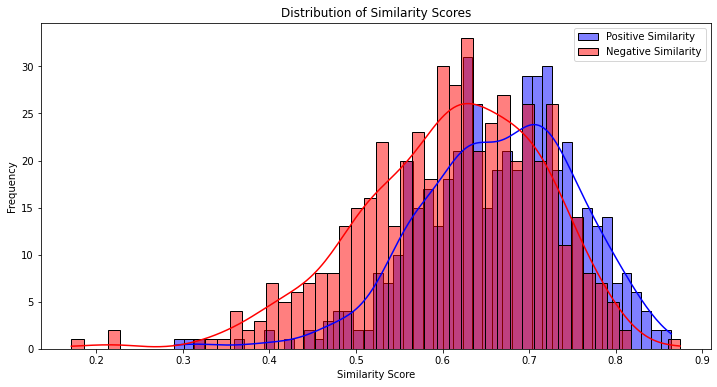

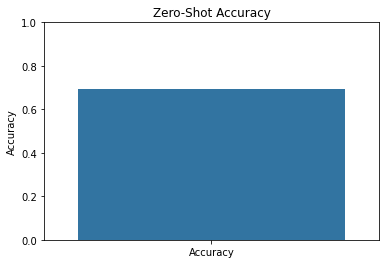

In [15]:
plot_metrics(metrics)